Citibike, a bike share program in NYC, collects, maintains, and makes public data about the entire bikeshare system and all rides made. On a personal level, Citibike allows users to download their trip history from the "Trips" link in their user profile. The available personal data consists of each trip's starting dock, starting time, ending dock, ending time and the duration of the trip. Fine location data is notably missing -- the bikes themselves do not contain any sort of location awareness.

While exploring this data and working some tools that are relatively new to me (Jupyter Notebook, pandas, etc.), I'll investigate some theories that I have about the way I ride, and some of the ways that Citibike as a whole operates. For exmaple, in the Citibike app, the program assumes that the rider rides [7.456 miles per hour](https://www.citibikenyc.com/system-data) when presenting the user with a "distance" for each of their completed rides. Do I ride faster or slower than that? Are my distance numbers underestimated or overestimated?

First, I'll start by reading a text file containing the trips exported from my user profile. Then, I'll clean up some of the data types and isolate unique trips by start and end stations.

In [21]:
import pandas as pd
import numpy as np
import googlemaps
import config

import matplotlib
import matplotlib.pyplot as plt

matplotlib.style.use('ggplot') 

gmaps = googlemaps.Client(key=config.gmaps_api_key)

In [22]:
# Read text file into pandas. By observation, use new line as separator declare no header so first line is read as data.
trips_df = pd.read_csv('trips.txt', sep="\n", header=None)

# Convert df from number_of_trips*5 by 1 to number_of_trips by 5
trips_df = (pd.DataFrame(np.reshape(trips_df.values,(round(len(trips_df)/5), 5)), 
                         columns=['start_time','start_loc','end_time','end_loc','duration']))

# Convert strings of times to datetimes
trips_df[['start_time','end_time']] = trips_df[['start_time','end_time']].apply(pd.to_datetime)

# Replace imported duration time with datetime calculated from start and end times.
trips_df['duration'] = trips_df['end_time'] - trips_df['start_time']

trips_df.head()

,start_time,start_loc,end_time,end_loc,duration
0,2018-04-28 14:24:58,Bond St & Fulton St,2018-04-28 15:12:36,11 St & 35 Ave,00:47:38
1,2018-04-24 08:09:43,1 Ave & E 68 St,2018-04-24 08:29:39,E 19 St & 3 Ave,00:19:56
2,2018-04-23 08:20:09,Bond St & Fulton St,2018-04-23 08:46:25,E 19 St & 3 Ave,00:26:16
3,2018-04-18 17:55:20,E 19 St & 3 Ave,2018-04-18 18:25:50,Bond St & Fulton St,00:30:30
4,2018-04-14 18:35:31,Central Park West & W 85 St,2018-04-14 18:47:31,E 71 St & 1 Ave,00:12:00


In [23]:
# Count number of trips that start and end at same station. For these trips, assume no meaningful travel. Sum durations for later reporting.
non_trips = sum(trips_df['start_loc'] == trips_df['end_loc'])
non_trips_time = trips_df[trips_df['start_loc'] == trips_df['end_loc']]['duration'].sum()

# Drop these trips, reset index.
trips_df.drop(trips_df[trips_df['start_loc'] == trips_df['end_loc']].index, inplace = True)
trips_df.reset_index(inplace = True, drop = True)

# Append city and state to locations to avoid ambiguity.

trips_df[['start_loc','end_loc']] = trips_df[['start_loc','end_loc']].astype(str) + ", New York, NY"

In [24]:
trips_df.head()

,start_time,start_loc,end_time,end_loc,duration
0,2018-04-28 14:24:58,"Bond St & Fulton St, New York, NY",2018-04-28 15:12:36,"11 St & 35 Ave, New York, NY",00:47:38
1,2018-04-24 08:09:43,"1 Ave & E 68 St, New York, NY",2018-04-24 08:29:39,"E 19 St & 3 Ave, New York, NY",00:19:56
2,2018-04-23 08:20:09,"Bond St & Fulton St, New York, NY",2018-04-23 08:46:25,"E 19 St & 3 Ave, New York, NY",00:26:16
3,2018-04-18 17:55:20,"E 19 St & 3 Ave, New York, NY",2018-04-18 18:25:50,"Bond St & Fulton St, New York, NY",00:30:30
4,2018-04-14 18:35:31,"Central Park West & W 85 St, New York, NY",2018-04-14 18:47:31,"E 71 St & 1 Ave, New York, NY",00:12:00


In [25]:
# Group and count rows where start_loc and end_loc have the same values. Reset index and rename column to be count.
# Create a unique df so as to minimize the number of hits on the Google Maps API.

unique = trips_df.groupby(['start_loc','end_loc']).size().reset_index().rename(columns= {0:'count'})
unique.head()

,start_loc,end_loc,count
0,"1 Ave & E 16 St, New York, NY","Duffield St & Willoughby St, New York, NY",1
1,"1 Ave & E 68 St, New York, NY","E 17 St & Broadway, New York, NY",1
2,"1 Ave & E 68 St, New York, NY","E 19 St & 3 Ave, New York, NY",14
3,"1 Ave & E 68 St, New York, NY","E 20 St & Park Ave, New York, NY",2
4,"1 Ave & E 68 St, New York, NY","E 44 St & 2 Ave, New York, NY",1


Finding the unique trips serves a two fold purpose, one, it's interesting to see which trips I take most frequently; and two, it will reduce the number of hits on the Google Maps API.

Here, I'll use the Google Maps Directions API to get bike directions. Since I rarely ride the wrong way on one way streets or go too far out of my way to find a bike lane, let's assume that I ride those routes for my trips.

In [6]:
# Define function that will use Google Maps API to retrieve assumed routes for all unique trips.

def get_bike_directions(row):
    origin = row['start_loc']
    destination = row['end_loc']
    mode = "bicycling"
    return gmaps.directions(origin, destination, mode)

directions = unique.apply(get_bike_directions, axis = 1)

In [26]:
unique['directions'] = directions

In [27]:
# Parse returned JSON to extract overall distance and overall duration of route.

unique['dist'] = unique['directions'].apply(lambda x : x[0]["legs"][0]['distance']['text'])
unique['google_time'] = unique['directions'].apply(lambda x : x[0]["legs"][0]['duration']['text'])

In [28]:
unique.head()

,start_loc,end_loc,count,directions,dist,google_time
0,"1 Ave & E 16 St, New York, NY","Duffield St & Willoughby St, New York, NY",1,"[{'bounds': {'northeast': {'lat': 40.7333362, ...",3.6 mi,22 mins
1,"1 Ave & E 68 St, New York, NY","E 17 St & Broadway, New York, NY",1,"[{'bounds': {'northeast': {'lat': 40.7652381, ...",3.5 mi,20 mins
2,"1 Ave & E 68 St, New York, NY","E 19 St & 3 Ave, New York, NY",14,"[{'bounds': {'northeast': {'lat': 40.7652381, ...",3.1 mi,17 mins
3,"1 Ave & E 68 St, New York, NY","E 20 St & Park Ave, New York, NY",2,"[{'bounds': {'northeast': {'lat': 40.7652381, ...",3.5 mi,20 mins
4,"1 Ave & E 68 St, New York, NY","E 44 St & 2 Ave, New York, NY",1,"[{'bounds': {'northeast': {'lat': 40.7652381, ...",1.8 mi,10 mins


Here, I left outer join "all trips" with "unique trips". A note: it would be more efficient to do the little bit of cleaning prior to the join.

In [29]:
trips_df = pd.merge(trips_df, unique, how='left', left_on=['start_loc','end_loc'], right_on=['start_loc','end_loc']).drop(['count'], axis =1)

In [30]:
trips_df['dist'] = trips_df['dist'].apply(lambda x : x[:-3])

In [31]:
trips_df = trips_df.rename(columns={'dist':'dist_miles'})

In [32]:
trips_df['speed_mph'] = trips_df['dist_miles'].astype(float) / (trips_df['duration']/np.timedelta64(1, 'h'))

In [33]:
trips_df.head()

,start_time,start_loc,end_time,end_loc,duration,directions,dist_miles,google_time,speed_mph
0,2018-04-28 14:24:58,"Bond St & Fulton St, New York, NY",2018-04-28 15:12:36,"11 St & 35 Ave, New York, NY",00:47:38,"[{'bounds': {'northeast': {'lat': 40.7628454, ...",7.5,43 mins,9.447166
1,2018-04-24 08:09:43,"1 Ave & E 68 St, New York, NY",2018-04-24 08:29:39,"E 19 St & 3 Ave, New York, NY",00:19:56,"[{'bounds': {'northeast': {'lat': 40.7652381, ...",3.1,17 mins,9.331104
2,2018-04-23 08:20:09,"Bond St & Fulton St, New York, NY",2018-04-23 08:46:25,"E 19 St & 3 Ave, New York, NY",00:26:16,"[{'bounds': {'northeast': {'lat': 40.7363809, ...",4.2,25 mins,9.593909
3,2018-04-18 17:55:20,"E 19 St & 3 Ave, New York, NY",2018-04-18 18:25:50,"Bond St & Fulton St, New York, NY",00:30:30,"[{'bounds': {'northeast': {'lat': 40.736971, '...",4.0,23 mins,7.868852
4,2018-04-14 18:35:31,"Central Park West & W 85 St, New York, NY",2018-04-14 18:47:31,"E 71 St & 1 Ave, New York, NY",00:12:00,"[{'bounds': {'northeast': {'lat': 40.784612, '...",3.1,20 mins,15.500000


I'll plot the ride speeds as a histogram to get a sense of the distribution of my ride speeds.

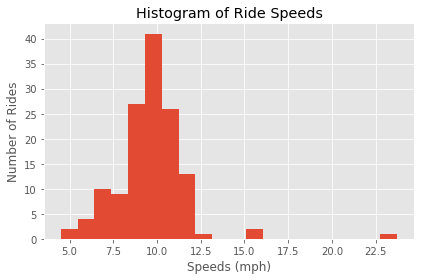

In [34]:
num_bins = 20
fig, ax = plt.subplots()

ax.hist(trips_df['speed_mph'], bins=num_bins)
ax.set_xlabel('Speeds (mph)')
ax.set_ylabel('Number of Rides')
ax.set_title('Histogram of Ride Speeds')

fig.tight_layout()
plt.show()

Seems like a pretty safe bet that I beat the Citibike bike assumed 7.456 mph. Let's take a look at those outliers.

In [35]:
trips_df[trips_df.speed_mph > 12]

,start_time,start_loc,end_time,end_loc,duration,directions,dist_miles,google_time,speed_mph
4,2018-04-14 18:35:31,"Central Park West & W 85 St, New York, NY",2018-04-14 18:47:31,"E 71 St & 1 Ave, New York, NY",00:12:00,"[{'bounds': {'northeast': {'lat': 40.784612, '...",3.1,20 mins,15.500000
20,2018-02-19 18:41:51,"Bond St & Fulton St, New York, NY",2018-02-19 18:50:57,"7 St & 3 Ave, New York, NY",00:09:06,"[{'bounds': {'northeast': {'lat': 40.7289111, ...",3.6,22 mins,23.736264
29,2017-12-16 20:57:11,"E 45 St & 3 Ave, New York, NY",2017-12-16 20:59:03,"E 47 St & 1 Ave, New York, NY",00:01:52,"[{'bounds': {'northeast': {'lat': 40.7533249, ...",0.4,3 mins,12.857143
46,2017-09-29 21:18:20,"Amsterdam Ave & W 82 St, New York, NY",2017-09-29 21:32:21,"1 Ave & E 68 St, New York, NY",00:14:01,"[{'bounds': {'northeast': {'lat': 40.7851039, ...",3.6,25 mins,15.410226


Luckily, these are my own rides so I can recall that I did indeed take shortcuts on id=4 and id=46 above. Also, at 23mph, that id=20 is a particularly egregious failing of my hacky attempt to prep the station locations for Google Maps API.

In [36]:
# Based on histogram above, assume that rides over 13 mph are erroneous -- i.e., I took a shortcut down a one-way compared
# to what Google suggested, or, for the > 20 mph ride, the address/pathfinding is wrong because of Brooklyn vs NY, NY.
trips_df = trips_df.drop(trips_df[trips_df.speed_mph > 13].index)

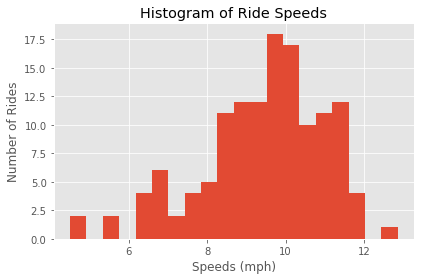

In [37]:
num_bins = 20
fig, ax = plt.subplots()

ax.hist(trips_df['speed_mph'], bins=num_bins)
ax.set_xlabel('Speeds (mph)')
ax.set_ylabel('Number of Rides')
ax.set_title('Histogram of Ride Speeds')

fig.tight_layout()
plt.show()

In [38]:
trips_df['speed_mph'].describe()

count    133.000000
mean       9.421751
std        1.576220
min        4.500000
25%        8.622754
50%        9.606742
75%       10.485437
max       12.857143
Name: speed_mph, dtype: float64

As guessed, on average, I ride faster than the Citibike app expects and the in-app distance numbers are underestimated.

In [52]:
trips_df.loc[trips_df.speed_mph.idxmin()]

start_time                                   2017-04-19 08:21:15
start_loc                      Bond St & Fulton St, New York, NY
end_time                                     2017-04-19 08:23:55
end_loc                Duffield St & Willoughby St, New York, NY
duration                                         0 days 00:02:40
directions     [{'bounds': {'northeast': {'lat': 40.6921215, ...
dist_miles                                                   0.2
google_time                                               2 mins
speed_mph                                                    4.5
Name: 122, dtype: object

The slowest trip I took, I recall being one where I had to fiddle with the seat and I docked it as soon as I could.

In [74]:
trip_time = trips_df['duration'].sum()

days = trip_time.days
hours, remainder = divmod(trip_time.seconds, 3600)
minutes, seconds = divmod(remainder, 60)

trip_time = days * 24 + hours + minutes/60


print("The total time spent riding Citibike is %.1f hours." % (trip_time))
print("The total distance traveled using Citibike is %.1f miles." % (trip_time*trips_df['speed_mph'].mean()))


The total time spent riding Citibike is 44.6 hours.
The total distance traveled using Citibike is 420.2 miles.
